# **Finetuning del modelo de Gemma2-9b con Unsloth**

Hacemos el finetuning con Unsloth del modelo Gemma2-9b.

Comenzamos con la instalación de Unsloth, que necesita hacer después una reiniciación de la sesión.

In [1]:
!pip install unsloth
!pip install --no-deps xformers trl peft accelerate bitsandbytes

Cargamos las funciones necesarias dentro de Unsloth, así como torch.

In [2]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Definimos otros parámetros.

In [3]:
max_seq_length = 2048 # Soporta hasta el límite de Gemma-2
dtype = None # Auto detección (Float16 para Tesla T4, Bfloat16 para A100/L4)
load_in_4bit = True # Usar cuantización de 4 bits para ahorrar memoria

Descargamos el modelo Gemma2-9b.

Nos sugiere que cargemos la librería flash-attn, pero lo hemos probado y tarda tanto que no lo hemos ejecutado finalmente. Gemini dice de todas formas que el finetuning debería de funcionar correctamente.

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2-9b-it-bnb-4bit", # Versión optimizada de Gemma-2-9b
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

Unsloth: If you want to finetune Gemma 2, install flash-attn to make it faster!
To install flash-attn, do the below:

pip install --no-deps --upgrade "flash-attn>=2.6.3"
==((====))==  Unsloth 2026.1.4: Fast Gemma2 patching. Transformers: 4.57.6.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

No ejecutar de nuevo la siguiente celda, tarda demasiado tiempo.

In [ ]:
pip install --no-deps --upgrade "flash-attn>=2.6.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 78.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Añadimos los adaptadores de LoRA, optimizado para Unsloth.

In [5]:
# Añadimos adaptadores LoRA para el fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Rango sugerido (puedes subir a 32 si tienes memoria libre)
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Optimizado para 0 en Unsloth
    bias = "none",    # Optimizado para "none"
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2026.1.4 patched 42 layers with 42 QKV layers, 42 O layers and 42 MLP layers.


Aquí ajustamos los datasets para hacer el finetuning. Lo cierto es que tuvimos que eliminar el campo de 'metadata', porque incluía en algunos casos listas (arrays), no solo texto, y daba errores.

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

def cargar_datos_seguro(ruta_train, ruta_test):
    # Pandas no se queja si una columna tiene tipos mezclados (la trata como 'object')
    df_train = pd.read_json(ruta_train, lines=True)
    df_test = pd.read_json(ruta_test, lines=True)

    # Opcional: Nos quedamos solo con lo que el modelo necesita para el fine-tuning
    # Esto evita que metadata cause errores más adelante
    df_train = df_train[['input_text', 'target_text']]
    df_test = df_test[['input_text', 'target_text']]

    # Convertimos de Pandas a Hugging Face Dataset
    ds_train = Dataset.from_pandas(df_train)
    ds_test = Dataset.from_pandas(df_test)

    return DatasetDict({"train": ds_train, "test": ds_test})

In [7]:
dataset = cargar_datos_seguro(
    "/content/drive/MyDrive/Practica_LLM_Engineering_25/dataset_t5_final/train.jsonl",
    "/content/drive/MyDrive/Practica_LLM_Engineering_25/dataset_t5_final/test.jsonl"
)

Formateamos los prompts para que sea compatible con el modelo.

In [8]:
prompt_style = """{}

{}

{}""" # Estructura: Instrucción, Contexto, Respuesta

def formatting_prompts_func(examples):
    inputs  = examples["input_text"]
    outputs = examples["target_text"]
    texts = []
    for input_text, output_text in zip(inputs, outputs):
        # Aquí SÍ usamos prompt_style para dar formato
        # El input_text ya trae los ### del JSONL, así que solo concatenamos
        text = prompt_style.format(input_text, "", output_text) + tokenizer.eos_token
        texts.append(text)
    return { "text" : texts, }

# Aplicamos el formato a ambos sets
dataset = dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Hacemos el finetuning, que me llevó algo más de una hora, y mostramos los errores de training y validación, estos últimos proveniente del dataset de test.

In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    args = TrainingArguments(
        per_device_train_batch_size = 1, # <--- Bajamos de 2 a 1
        gradient_accumulation_steps = 8, # <--- Subimos de 4 a 8 (para mantener el batch total en 8)
        warmup_steps = 5,
        num_train_epochs = 3,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        eval_strategy = "steps",       # Evaluar cada cierto número de pasos
        eval_steps = 10,
        logging_steps = 1,
        optim = "adamw_8bit",            # <--- Asegúrate de que esto sea 8bit
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        save_strategy = "no",            # <--- Evita guardar checkpoints intermedios que ocupan RAM
    ),
)

trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1440 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/180 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,440 | Num Epochs = 3 | Total steps = 540
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 54,018,048 of 9,295,724,032 (0.58% trained)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss,Validation Loss
10,0.980100,1.065960
20,1.098000,0.715882
30,0.435800,0.562768
40,0.787800,0.507016
50,0.331300,0.456958
60,0.296100,0.429485
70,0.298000,0.405864
80,0.346100,0.388252
90,0.823000,0.385376
100,0.798600,0.370467


Unsloth: Not an error, but Gemma2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss,Validation Loss
10,0.980100,1.065960
20,1.098000,0.715882
30,0.435800,0.562768
40,0.787800,0.507016
50,0.331300,0.456958
60,0.296100,0.429485
70,0.298000,0.405864
80,0.346100,0.388252
90,0.823000,0.385376
100,0.798600,0.370467


eval/loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁███████████████████████████████████████
eval/steps_per_second,▁█████████████▇█████████████████████████
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇█████
train/grad_norm,█▂▄▃▂▃▃▂▃▂▂▃▁▃▄▃▄▁▃▃▁▁▂▃▃▁▄▂▁▁▁▂▃▅▄▂▄▃▅▆
train/learning_rate,▁▄▇██▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁
train/loss,▅▃▃▃▇█▃▅█▆▆▆▁█▆▅▁▄▁▄▅▅▆▂▁▁▆▄▃▂▃▄▄▄▃▁▁▂▃▁
eval/loss,0.32199
eval/runtime,43.1849


TrainOutput(global_step=540, training_loss=0.4611411186831969, metrics={'train_runtime': 4749.8158, 'train_samples_per_second': 0.91, 'train_steps_per_second': 0.114, 'total_flos': 4.592268288295834e+16, 'train_loss': 0.4611411186831969, 'epoch': 3.0})

Intenté gravar el modelo en Drive a 16 bits, pero, aunque aparecían las shards en el directorio, su contenido estaba aparentemente corrupto. Google Drive no parece haber cargado realmente los shards, porque no aparece en la memoria utilizada o como diferencia en la disponible.

In [ ]:
# model.save_pretrained_merged("/content/drive/MyDrive/Practica_LLM_Engineering_25/modelo-Gemma_2-9b-finetuned", tokenizer, save_method = "merged_16bit")

config.json:   0%|          | 0.00/927 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [00:19<00:58, 19.34s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [00:37<00:37, 18.68s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [00:57<00:19, 19.05s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [02:28<00:00, 37.20s/it]


Unsloth: Merge process complete. Saved to `/content/drive/MyDrive/Practica_LLM_Engineering_25/modelo-Gemma_2-9b-finetuned`


Intenté subir el modelo entonces a 8 bits, pero también he tenido problemas.

In [14]:
model.save_pretrained_merged("/content/drive/MyDrive/Practica_LLM_Engineering_25/modelo-Gemma_2-9b-finetuned-8bit", tokenizer, save_method = "merged_8bit")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [02:56<08:49, 176.61s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [03:42<03:19, 99.62s/it] 

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [04:01<01:02, 62.93s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [02:08<00:00, 32.13s/it]


Unsloth: Merge process complete. Saved to `/content/drive/MyDrive/Practica_LLM_Engineering_25/modelo-Gemma_2-9b-finetuned-8bit`


Aquí tenemos las gráficas de las losses de train y test. Lo cierto es que parece un resultado excelente, con un descenso constante de la volatilidad en train, y con resultados en validación que fueron convergiendo rápidamente. Pienso que las 3 epochs son el sweet spot.

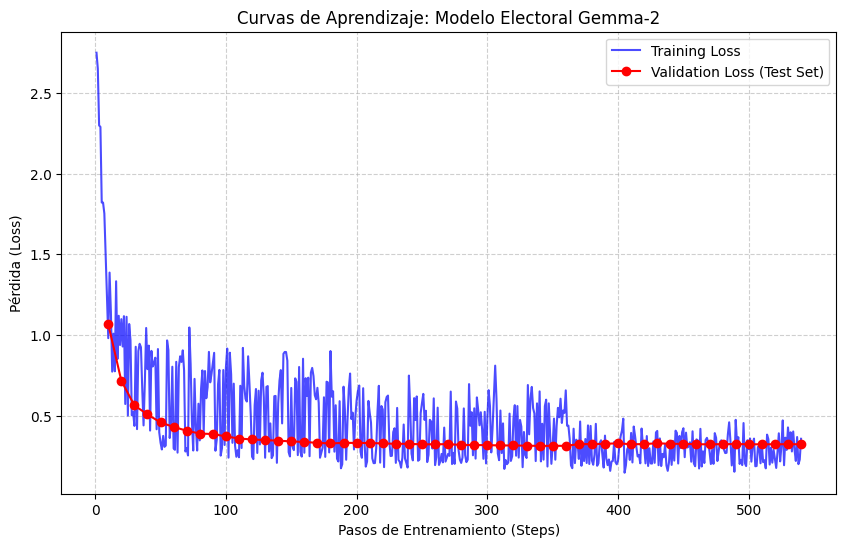

In [10]:
import matplotlib.pyplot as plt

# Extraer los logs del historial del trainer
history = trainer.state.log_history

train_loss = [x['loss'] for x in history if 'loss' in x]
train_steps = [x['step'] for x in history if 'loss' in x]

val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
val_steps = [x['step'] for x in history if 'eval_loss' in x]

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.7)
if val_loss:
    plt.plot(val_steps, val_loss, label='Validation Loss (Test Set)', color='red', marker='o')

plt.title('Curvas de Aprendizaje: Modelo Electoral Gemma-2')
plt.xlabel('Pasos de Entrenamiento (Steps)')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [12]:
plt.savefig('/content/drive/MyDrive/Practica_LLM_Engineering_25/grafica_entrenamiento_gemma_2-9b_nueva.png')

<Figure size 640x480 with 0 Axes>

Probamos el modelo ya finetuneado, y como comentamos en la memoria de la práctica, el resultado parece claramente mejor que en el caso del finetuning del modelo T5.

In [ ]:
import json

# Ponemos el modelo en modo inferencia
FastLanguageModel.for_inference(model)

# Cargamos unas muestras de tu archivo de test para comparar
test_samples = []
with open("/content/drive/MyDrive/Practica_LLM_Engineering_25/dataset_t5_final/test.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        test_samples.append(json.loads(line))

print("--- VALIDACIÓN DE RESULTADOS ---\n")

for i, sample in enumerate(test_samples[:5]): # Probamos los primeros ejemplos
    instruccion_y_contexto = sample["input_text"]
    respuesta_esperada = sample["target_text"] # [cite: 1, 2, 3]

    inputs = tokenizer([instruccion_y_contexto], return_tensors = "pt").to("cuda")

    # Generamos la respuesta del modelo
    outputs = model.generate(**inputs, max_new_tokens = 150, use_cache = True)
    respuesta_modelo = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Limpiamos la salida para ver solo la respuesta nueva
    solo_respuesta = respuesta_modelo.split("### Respuesta:")[-1].strip()

    print(f"EJEMPLO {i+1}:")
    print(f"PREGUNTA id: {sample['metadata']['id']}") # [cite: 1, 2, 3]
    print(f"PREGUNTA texto: {sample['input_text']}")
    print(f"ESPERADO: {respuesta_esperada}")
    print(f"MODELO:   {solo_respuesta}")
    print("-" * 30)

--- VALIDACIÓN DE RESULTADOS ---

EJEMPLO 1:
PREGUNTA id: nivel2_474
PREGUNTA texto: ### Instrucción:
¿Cómo evolucionó el porcentaje de voto a VOX en Medina del Campo entre Noviembre 2019 y Abril 2019?

### Contexto:
Municipio: Medina del Campo, Partido: VOX, Años: Noviembre 2019 y Abril 2019

### Respuesta:
ESPERADO: El VOX en Medina del Campo pasó de 19.86% en Noviembre 2019 a 13.75% en Abril 2019. Esto representa una disminución de 6.11 puntos porcentuales (30.8% menos).
MODELO:   El VOX en Medina del Campo pasó de 16.18% en Noviembre 2019 a 11.86% en Abril 2019. Esto representa una disminución de 4.32 puntos porcentuales (26.7% menos).
------------------------------
EJEMPLO 2:
PREGUNTA id: nivel2_396
PREGUNTA texto: ### Instrucción:
¿Cuál fue el cambio porcentual del voto a VOX en Mahora entre las elecciones de Noviembre 2019 y Abril 2019?

### Contexto:
Municipio: Mahora, Partido: VOX, Años: Noviembre 2019->Abril 2019

### Respuesta:
ESPERADO: El VOX en Mahora pasó de 20.92% en po

Finalmente, decidí grabar el modelo en 4 bits, y no ha habido problemas que haya detectado.

In [ ]:
model.save_pretrained_merged("/content/drive/MyDrive/Practica_LLM_Engineering_25/modelo-Gemma_2-9b-finetuned-4bit", tokenizer, save_method = "merged_4bit_forced")

Unsloth: Merging LoRA weights into 4bit model...


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Unsloth: Merging finished.
Unsloth: Found skipped modules: ['lm_head']. Updating config.
Unsloth: Saving merged 4bit model to /content/drive/MyDrive/Practica_LLM_Engineering_25/modelo-Gemma_2-9b-finetuned-4bit...
Unsloth: Merged 4bit model saved.
Unsloth: Merged 4bit model process completed.
